In [1]:
import pandas as pd
import numpy as np
import re
import string
import gensim
import time
import json


import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

import multiprocessing as mp
from spellchecker import SpellChecker

import torch
import torch.nn as nn
import torch.optim as optim
import math
from argparse import Namespace

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import codecs

# Init

In [2]:
if not nltk.find('corpora/wordnet'):
     nltk.download('wordnet')
porter_stemmer  = PorterStemmer()
lemmatizer      = WordNetLemmatizer()
regex_tokenizer = nltk.tokenize.RegexpTokenizer(r"\w+")
spell  = SpellChecker()
one_hot_vectorizer = CountVectorizer(binary=True)
args = Namespace(
    degree_injury_file="./data/degreeinjury.csv",
    injury_bodyparts_file="./data/injurybodyparts.csv",
    NER_file="./data/ner.csv",
    ner_accident = 'us_accidents.txt',
    clf_accident = 'us_data_2000.csv',
    
)

# Functions

In [3]:
def clean_text(text):
    txt = ''
    txt = txt.strip()
    txt = re.sub(r"([.,!?])", r" \1 ", txt)
    for word in tokenize(text):
        # The EE is short hand on employee
        if word=='ee' or word == 'EE':
            txt += ' employee '
        elif word in string.punctuation:
            txt = txt + ' ' +word
        elif len(word)>2:
            word = spell.correction(word)
            txt = txt + ' ' + word.lower().strip()
    txt = re.sub(r"[^a-zA-Z.,!?]+", r" ", txt)
    return txt.strip()

def tokenize(text):
    return nltk.word_tokenize(text)

def stem(words, df=False):
    stemmed_words=[porter_stemmer.stem(word) for word in words]
    if df:
        return pd.DataFrame({'original': words,'stemmed': stemmed_words})
    return stemmed_words

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return None

def lemmatize(words, df=False):
    lemmatized_words=[]
    tagged_sent = nltk.pos_tag(words)
    
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or nltk.corpus.wordnet.NOUN
        if wordnet_pos is None:
            spell.correction(lemmatized_words.append(lemmatizer.lemmatize(tag[0])))
        else:
            lemmatized_words.append(spell.correction(lemmatizer.lemmatize(tag[0], pos=wordnet_pos)))
    
    if df:
        return pd.DataFrame({'original': words,'lemmatized': lemmatized_words})
    return lemmatized_words

def lemmatize_word(word):
    tagged_sent = nltk.pos_tag([word])
    wordnet_pos = get_wordnet_pos(tagged_sent[0][1]) or nltk.corpus.wordnet.NOUN
    if wordnet_pos is None:
        return lemmatizer.lemmatize(tagged_sent[0][0])
    else:
        return lemmatizer.lemmatize(tagged_sent[0][0], pos=wordnet_pos)

def SK_TFIDF_stopwords(corpus, vectorizer):
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    return vectorizer.stop_words_, X

def get_words(texts):
    words = []
    for text in texts:
        words+=regex_tokenizer.tokenize(text)
    return np.asarray(words).reshape(-1, 1)

def spell_check(words):
    return [spell.correction(word) for word in words]

def remove_stopwords(words, stopwords):
    return [w for w in words if w not in stopwords]

def split_save(data, path, test=0.2, valid= 0.1, stratify=True):
    if stratify:
        train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True, stratify=data['target'])
        train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True, stratify=train['target'])
    else:
        train, test  = train_test_split(data,  test_size=test, random_state=666, shuffle=True)
        train, valid = train_test_split(train, test_size=valid, random_state=666, shuffle=True)
    train['split'] = 'train'
    test['split']  = 'test'
    valid['split'] = 'val'
    pd.concat([train, valid, test]).to_csv(path, index=False)

# Clean Narrative
#### Clean Narrative is computionally expensive run if only necessary

In [4]:
df = pd.read_csv(args.clf_accident)
df = df[['DEGREE_INJURY', 'DEGREE_INJURY_CD', 'INJ_BODY_PART_CD', 'INJ_BODY_PART', 'NARRATIVE']]
df.head(1)

,DEGREE_INJURY,DEGREE_INJURY_CD,INJ_BODY_PART_CD,INJ_BODY_PART,NARRATIVE
0,DAYS RESTRICTED ACTIVITY ONLY,5,700,MULTIPLE PARTS (MORE THAN ONE MAJOR),Employee was cleaning up at the Primary Crushe...


In [5]:
df.isnull().any()

DEGREE_INJURY       False
DEGREE_INJURY_CD    False
INJ_BODY_PART_CD    False
INJ_BODY_PART       False
NARRATIVE           False
dtype: bool

In [6]:
print('NARRATIVE NaN count:   ', df[df['NARRATIVE'].isna()].shape[0])
print('NARRATIVE len>10 count:', df[df['NARRATIVE'].str.len() < 10].shape[0])
print('\nDEGREE_INJURY_CD "?" count: ', df[df['DEGREE_INJURY_CD'] == '?'].shape[0])
print('\nINJ_BODY_PART_CD "?" count: ', df[df['INJ_BODY_PART_CD'] == '?'].shape[0])

NARRATIVE NaN count:    0
NARRATIVE len>10 count: 1

DEGREE_INJURY_CD "?" count:  11

INJ_BODY_PART_CD "?" count:  242


#### Remove Narrative are too short and NA

In [7]:
print("Origin data size:      ", df.shape[0])
df = df[df['NARRATIVE'].notna()]
df = df[df['NARRATIVE'].str.len() > 10]
print("Clean data size:", df.shape[0])

Origin data size:       2000
Clean data size: 1999


### To Lower case and correct words

In [8]:
with mp.Pool(mp.cpu_count()) as pool:
    df['NARRATIVE'] = pool.map(clean_text, df['NARRATIVE'])
df['NARRATIVE'].values[0]

'employee was cleaning the primary crusher with the dingo skid steer . the employee slipped and fell while operating the skid steer and the machine pinned him against the cement retaining wall .'

### Dataset for task 1

In [9]:
df_degree=df[['NARRATIVE', 'DEGREE_INJURY_CD', 'DEGREE_INJURY']].copy()
df_degree = df_degree[df_degree['DEGREE_INJURY_CD'] != '?']
df_degree['DEGREE_INJURY_CD'] = pd.to_numeric(df_degree['DEGREE_INJURY_CD'])

def get_degree_injury(dataframe):
    CD = []
    INJURY = []
    for i in range(0, len(dataframe.DEGREE_INJURY_CD.unique())):
        CD.append(i)
        INJURY.append(dataframe[dataframe['DEGREE_INJURY_CD'] == i]['DEGREE_INJURY'].values[0])
    return pd.DataFrame({'DEGREE_INJURY_CD': CD,'DEGREE_INJURY': INJURY})

get_degree_injury(df_degree)

,DEGREE_INJURY_CD,DEGREE_INJURY
0,0,ACCIDENT ONLY
1,1,FATALITY
2,2,PERM TOT OR PERM PRTL DISABLTY
3,3,DAYS AWAY FROM WORK ONLY
4,4,DYS AWY FRM WRK & RESTRCTD ACT
5,5,DAYS RESTRICTED ACTIVITY ONLY
6,6,"NO DYS AWY FRM WRK,NO RSTR ACT"
7,7,OCCUPATNAL ILLNESS NOT DEG 1-6
8,8,INJURIES DUE TO NATURAL CAUSES
9,9,INJURIES INVOLVNG NONEMPLOYEES


In [10]:
100*df_degree['DEGREE_INJURY'].value_counts(normalize=True)

DAYS AWAY FROM WORK ONLY          29.879276
NO DYS AWY FRM WRK,NO RSTR ACT    27.766600
DAYS RESTRICTED ACTIVITY ONLY     18.058350
ACCIDENT ONLY                     11.016097
DYS AWY FRM WRK & RESTRCTD ACT     7.293763
OCCUPATNAL ILLNESS NOT DEG 1-6     2.867203
ALL OTHER CASES (INCL 1ST AID)     1.006036
PERM TOT OR PERM PRTL DISABLTY     0.905433
FATALITY                           0.553320
INJURIES DUE TO NATURAL CAUSES     0.503018
INJURIES INVOLVNG NONEMPLOYEES     0.150905
Name: DEGREE_INJURY, dtype: float64

### Group and save

In [11]:
group1 = [
    'DAYS AWAY FROM WORK ONLY',
    'DAYS RESTRICTED ACTIVITY ONLY',
    'DYS AWY FRM WRK & RESTRCTD ACT'
]
df_degree['target'] = df_degree['DEGREE_INJURY'].isin(group1)
df_degree["target"] = df_degree["target"].astype(str)
del df_degree['DEGREE_INJURY']
del df_degree['DEGREE_INJURY_CD']
split_save(df_degree, path=args.degree_injury_file)

### Check balance

In [12]:
100*df_degree['target'].value_counts(normalize=True)

True     55.231388
False    44.768612
Name: target, dtype: float64

<AxesSubplot:title={'center':'Target class balance'}, xlabel='target'>

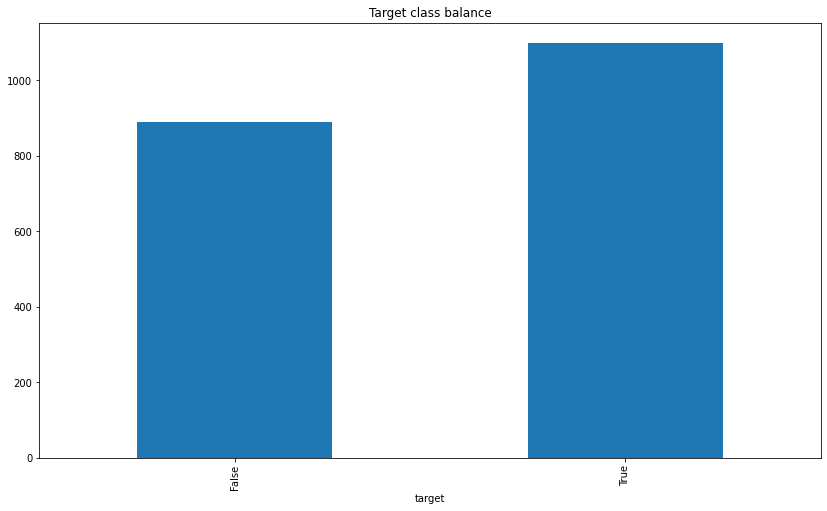

In [13]:
df_degree.groupby(['target'])['target'].count().plot.bar(title="Target class balance", figsize=(14,8))

10% more class in True label

### Dataset for task 2

In [14]:
HEAD     = ['SKULL', 'EAR(S) INTERNAL & HEARING', 'EAR(S) EXTERNAL', 'EAR(S) INTERNAL & EXTERNAL' ,'EYE(S) OPTIC NERVE/VISON', 'NOSE/NASAL PASSAGES/SINUS/SMELL', 'EAR(S) INTERNAL & HEARING', 'BRAIN', 'FACE,NEC', 'FACE, MULTIPLE PARTS', 'HEAD, MULTIPLE PARTS', 'HEAD,NEC', 'MULTIPLE PARTS', 'MOUTH/LIP/TEETH/TONGUE/THROAT/TASTE', 'JAW INCLUDE CHIN', 'SCALP', 'NECK']
LEG      = ['LEG, MULTIPLE PARTS', 'LOWER LEG/TIBIA/FIBULA', 'FOOT(NOT ANKLE/TOE)/TARSUS/METATARSUS', 'LEG, NEC', 'KNEE/PATELLA', 'TOE(S)/PHALANGES', 'ANKLE', 'THIGH/FEMUR', 'LOWER EXTREMITIES,NEC', 'LOWER EXTREMITIES, MULTIPLE PARTS']
ARM      = ['ARM, MULTIPLE PARTS', 'ARM,NEC', 'HAND (NOT WRIST OR FINGERS)', 'WRIST', 'FINGER(S)/THUMB', 'UPPER ARM/HUMERUS', 'SHOULDERS (COLLARBONE/CLAVICLE/SCAPULA)', 'ELBOW', 'FOREARM/ULNAR/RADIUS', 'UPPER EXTREMITIES, MULTIPLE', 'UPPER EXTREMITIES, NEC']
BODY     = ['CHEST (RIBS/BREAST BONE/CHEST ORGNS)', 'BODY SYSTEMS', 'ABDOMEN/INTERNAL ORGANS', 'BODY PARTS, NEC', 'TRUNK, MULTIPLE PARTS', 'TRUNK,NEC', 'HIPS (PELVIS/ORGANS/KIDNEYS/BUTTOCKS)', 'BACK (MUSCLES/SPINE/S-CORD/TAILBONE)']
MULTIPLE = ['MULTIPLE PARTS (MORE THAN ONE MAJOR)']

df_parts=df[['NARRATIVE', 'INJ_BODY_PART_CD', 'INJ_BODY_PART']].copy()
df_parts = df_parts[df_parts['INJ_BODY_PART_CD'] != '?']
del df_parts['INJ_BODY_PART_CD']

df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(HEAD)]     = 'Head'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(LEG)]      = 'Leg'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(ARM)]      = 'Arm'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(BODY)]     = 'Body'
df_parts['INJ_BODY_PART'][df_parts['INJ_BODY_PART'].isin(MULTIPLE)] = 'Multiple Parts'
df_parts['target'] = df_parts['INJ_BODY_PART']
df_parts = df_parts[df_parts['target']!='UNCLASSIFIED']
del df_parts['INJ_BODY_PART']
split_save(df_parts, path=args.injury_bodyparts_file)
print("classes", set(df_parts.target))
print("Instances", df_parts.shape[0])

classes {'Head', 'Multiple Parts', 'Body', 'Arm', 'Leg'}
Instances 1755


In [15]:
100*df_parts['target'].value_counts(normalize=True)

Arm               36.524217
Body              21.766382
Leg               20.512821
Head              15.270655
Multiple Parts     5.925926
Name: target, dtype: float64

<AxesSubplot:title={'center':'Target class balance'}, xlabel='target'>

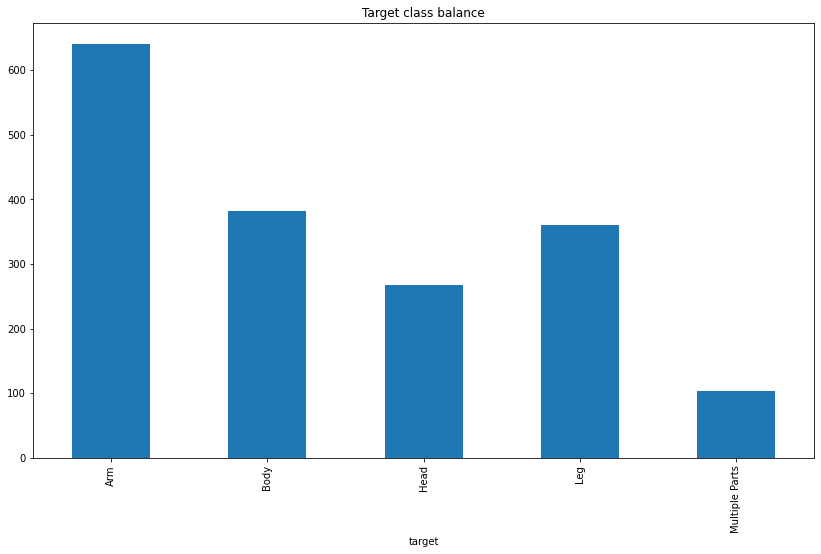

In [16]:
df_parts.groupby(['target'])['target'].count().plot.bar(title="Target class balance", figsize=(14,8))

Even the class is not balance, `Arm` has the most instances, and `Multiple Parts` has least instances. So when evaulate the model build from this class we need to look at the confusion matrix to get a better understaind on the actual pefromance.

### Dataset for task 3

In [17]:
'''
Correct word and lemmatize word, also remove words lenght < 1, and
merge lines sentences sepreated by |
'''
texts = []
entities = []
text = ''
entity=''
with codecs.open(args.ner_accident, 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        if line.strip() == '' and text !=  '':
            texts.append(text[:-1])
            entities.append(entity[:-1])
            text = ''
            entity=''
        else:
            try:
                pos = line.strip().split(' ')
                if len(pos) == 2:
                    if len(pos[0].strip()) > 1:
                        text   += lemmatize_word(pos[0].strip()) + '|'
                        entity += pos[1] + '|'
                elif len(pos)>2:
                    multi = ''
                    for word in pos[:-1]:
                        tmp = word.strip()
                        if tmp  == '' or tmp  == "''" :
                            continue
                        
                        if tmp not in string.punctuation:
                            if len(tmp) > 1:
                                multi  += lemmatize_word(tmp) + '-'
        
                    if len(multi)>0:
                        entity += pos[-1].strip() + '|'
                        text += multi + "|"
                        
                if len(text[:-1].split('|')) != len(entity[:-1].split('|')):
                    print(line)
                    print(text[:-1].split('|'), len(text[:-1].split('|')))
                    print(entity[:-1].split('|'), len(entity[:-1].split('|')))
                    break
            except Exception as e:
                print(e)
df_ner = pd.DataFrame({"NARRATIVE": texts,"target":entities})

# Save data set and split to train, vald and test
split_save(df_ner, path=args.NER_file, stratify=False)

In [18]:
df_ner.head()

,NARRATIVE,target
0,he|be|pull|54|inch|wiper|and|felt|pain|in|his|...,O|O|O|O|O|O|O|O|O|O|O|O|O
1,breathing|difficulty|employee|provide|first|no...,O|O|B-person/employee|O|O|O|O|O|O|O
2,while|palletizing|flat|rock|landscape|stone|in...,O|O|O|O|O|O|B-person/injured_person|I-person/i...
3,employee|be|help|load|bolt|on|roof|bolter|on|s...,B-person/employee|O|O|O|O|O|O|O|O|O|O|O|O|O|O|...
4,employee|step|into|hot|feed|and|fell|while|loo...,B-person/employee|O|O|O|O|O|O|O|O|O|O|O|O|O


## Data Prepreocessing and Preparation 

#### Test lem and stem

In [19]:
df_stem      = stem(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_lemmatize = lemmatize(nltk.tokenize.word_tokenize((df['NARRATIVE'].values[0])), df=True)
df_stem['lemmatized'] = df_lemmatize['lemmatized']

In [20]:
df_stem[df_stem['stemmed'] != df_stem['lemmatized']]

,original,stemmed,lemmatized
0,employee,employe,employee
1,was,wa,be
4,primary,primari,primary
13,employee,employe,employee
18,operating,oper,operate
24,machine,machin,machine


### Test Stopwords

In [21]:
vectorizer = TfidfVectorizer(max_df=0.1, min_df=1)
_df = df[["NARRATIVE"]].copy()
_df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: tokenize(x))
_df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: lemmatize(x))
# _df['NARRATIVE'] = _df['NARRATIVE'].apply(lambda x: stem(x))

stopwrods, X = SK_TFIDF_stopwords(_df['NARRATIVE'].apply(lambda x: ' '.join(x)), vectorizer)

terms = vectorizer.get_feature_names()

# sum tfidf frequency of each term through documents
sums = X.sum(axis=0)

# connecting term to its sums frequency
data = []
for col, term in enumerate(terms):
    data.append( (term, sums[0,col] ))
print('Number of stopwords:', len(stopwrods))
print('Number of terms    :', len(terms))

ranking = pd.DataFrame(data, columns=['term','rank'])
print('Ascending')
print(ranking.sort_values('rank', ascending=True)[0:15])

print('\nDescending')
print(ranking.sort_values('rank', ascending=False)[0:15])

Number of stopwords: 27
Number of terms    : 3490
Ascending
               term      rank
938       elevation  0.142870
2140  perpendicular  0.142870
225            baby  0.148709
3022       swelling  0.148709
38      acupuncture  0.148709
3280    unknowingly  0.152673
3170            tow  0.158576
2724        silicon  0.158644
144      applicator  0.158644
1012       exercise  0.158733
2105    participate  0.158733
1463            ind  0.163071
143     application  0.167219
1165          forth  0.167219
913          easier  0.167219

Descending
       term       rank
2537   rock  43.318376
343    bolt  42.419348
2904   step  36.437109
2163  piece  34.777588
1147   foot  34.305766
2086   pain  33.967999
3217  truck  32.264098
1075   felt  31.611745
1371    hit  30.991819
289    belt  30.732714
1608   knee  29.773345
857    down  29.420928
1230    get  29.276470
1364    him  29.055487
1529   into  28.951256


/home/cun/anaconda3/envs/CITS4012/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [22]:
# Add words that could be meaningless
for w in ['abb','abc','dia', 'yes','yee', 'that', 'ind', 'wd', 'to', 'him']:
        stopwrods.add(w)

In [23]:
print(stopwrods)

{'that', 'cut', 'fall', 'wd', 'him', 'not', 'be', 'to', 'ind', 'hand', 'employee', 'out', 'dia', 'his', 'strike', 'left', 'slip', 'when', 'abb', 'with', 'off', 'work', 'from', 'the', 'finger', 'abc', 'yes', 'yee', 'fell', 'and', 'have', 'right', 'while', 'roof', 'back', 'cause'}


# Function repeative Prepreocessing and Preparation

In [24]:
def tok_lem_sem(text):
    words = tokenize(text)
    words = lemmatize(words)
#     words = stem(words)
    return words

def removestop_join(words, stopwords):
    words = remove_stopwords(words, stopwords)
    return ' '.join(words)

def prepreocessing(data, stop, target="NARRATIVE"):
    _df=data.copy()
    with mp.Pool(mp.cpu_count()) as pool:
        _df[target] = pool.map(tok_lem_sem, _df[target])
    _df[target] = _df.apply(lambda row: removestop_join(row[target], stop), axis=1)
    return _df

In [25]:
# Dataset For task 1

In [26]:
prepreocessing(pd.read_csv(args.degree_injury_file), stopwrods).to_csv(args.degree_injury_file, index=False)

In [27]:
# Dataset For task 2

In [28]:
prepreocessing(pd.read_csv(args.injury_bodyparts_file), stopwrods).to_csv(args.injury_bodyparts_file, index=False)

# Vectorizers is create for each task before model building

see task_1, task_2, ner, Transformer